*Updated x-x-2022*

Thank you for your interest in this work! Here's what you'll find below:

1.
2.
3.
4.
5.

# Initial Setup, Data Imports, Cleaning, Etc.

**Package import statements**

In [1]:
#I don't need all of these but I don't much feel like spending the time to check all the code to confirm the absence

import pandas as pd #dataframe package
import os           #for navigating xml library
import json         #for navigating json
#import ijson        #same
from pandas.io.json import json_normalize #same
import numpy as np  #habit
import itertools
import random
import ast
from collections import Counter
from collections import OrderedDict
import collections
import ast
import time
import re
import matplotlib.pyplot as plt

import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering #Turns out this was a bad idea

import scipy.cluster.hierarchy as shc

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools
import string
import random

from nltk.corpus import stopwords

**Stopwords for NLP**

This is a combination of:

* A base list of stopwords I found somewhere on the internet, sorry for poor sourcing
* Words and phrases like "Clue Crew" and "Jeopardy!" that interfered with the clustering process
* Words and half-words like "u" and "s" that popped up during the flashcard-generating process that weren't useful information

In [2]:
stopwords_list = ["u", "s", ":", "this", "'s", ",", "'", ".", "i",\
                  "me", "my", "myself", "we", "our", "ours", "ourselves",\
                  "you", "your", "yours", "yourself", "yourselves", "he",\
                  "him", "his", "himself", "she", "her", "hers", "herself","also",\
                  "it", "its", "itself", "they", "them", "their", "theirs", "themselves",\
                  "what", "which", "who", "whom", "this", "that", "these", "those", "am",\
                  "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",\
                  "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if",\
                  "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",\
                  "against", "between", "into", "through", "during", "before", "after", "above", "below",\
                  "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further",\
                  "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",\
                  "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",\
                  "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now",';',\
                  '(',')','1','2','3','4','5','6','7','8','9','10','#','!','&','``',"''",'\\','wa',"n't",\
                  'clue', 'crew', 'jimmy', 'sarah', 'jeopardy', 'jeopardy!', 'nt',
                  '__', '___', '____', '_____', '______', '_______', '________', '_________', 'blank', 'wa']

**Dataset Imports**

Updated version of this dataset available here: https://github.com/jwolle1/jeopardy_clue_dataset

In [3]:
j = pd.read_csv('C:/Users/Zach Gozlan/Documents/GitHub/jeopardy_clue_dataset/combined_season1-36.tsv', sep='\t', header=0)

#the j stands for jeopardy

**Lemmatization, Cleaning, Prep Steps**

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
#Cleaning questions (answers, Jeopardy! is weird like that. I mean technically they're "responses" anyway.)

question_mod = [word_tokenize(item) for item in j.question]

question_mod_2 = list()

for item in question_mod:
    item = [lemmatizer.lemmatize(word) for word in item]
    question_mod_2.append(item)
    
question_mod_3 = list()

for item in question_mod:
    item = [x.lower() for x in item if x.lower() not in stopwords_list]
    question_mod_3.append(item)
    
j['question_modified'] = [' '.join(item) for item in question_mod_3]

In [6]:
#cleaning answers (THE THING THEY ASK YOU MAN IDK WHAT ELSE TO CALL IT)

answer_mod = [word_tokenize(item) for item in j.answer]

answer_mod_2 = list()

for item in answer_mod:
    item = [lemmatizer.lemmatize(word) for word in item]
    answer_mod_2.append(item)
    
answer_mod_3 = list()

for item in answer_mod_2:
    item = [x.lower() for x in item if x.lower() not in stopwords_list]
    answer_mod_3.append(item)
    
j['answer_modified'] = answer_mod_3

j['question_modified'] = [item.translate(str.maketrans('', '', string.punctuation)) for item in j.question_modified]
j['question_modified'] = [item.strip() for item in j.question_modified]

After these steps, what I have now is a column ("question_modified") which is the answer to the clue and a list ("answer_modified") of the most important words related to that clue.

You also see some imperfections of this method - "tae kwon do" becoming "tae kwon" because 'do' is a common English word - but considering the scale we're working at here and that this was a personal project these small issues didn't amount to enough to warrant the energy necessary to clean it up.

In [7]:
j[310012:310022]

,round,value,daily_double,category,comments,answer,question,air_date,notes,question_modified,answer_modified
310012,1,400,no,"ENDS IN ""O\""",-,"A small dagger, or a high, very thin heel on a...",a stiletto,2015-06-16,-,stiletto,"[small, dagger, high, thin, heel, woman, shoe]"
310013,1,600,no,"ENDS IN ""O\""",-,It's the traditional 7-letter cry on first sig...,tally-ho,2015-06-16,-,tallyho,"[traditional, 7-letter, cry, first, sighting, ..."
310014,1,800,no,"ENDS IN ""O\""",-,This martial art is the short Korean phrase fo...,tae kwon do,2015-06-16,-,tae kwon,"[martial, art, short, korean, phrase, strike, ..."
310015,1,1000,no,"ENDS IN ""O\""",-,One of the last entries in a dictionary is thi...,zydeco,2015-06-16,-,zydeco,"[one, last, entry, dictionary, type, cajun, da..."
310016,1,200,no,FOOD STUFF,-,Kalamata & Spanish are types of these,olives,2015-06-16,-,olives,"[kalamata, spanish, type]"
310017,1,400,no,FOOD STUFF,-,Thin pieces of dough are called these Chinese ...,wontons,2015-06-16,-,wontons,"[thin, piece, dough, called, chinese, dumpling..."
310018,1,600,no,FOOD STUFF,-,"This Mexican appetizer, a tortilla filled with...",quesadilla,2015-06-16,-,quesadilla,"[mexican, appetizer, tortilla, filled, cheese,..."
310019,1,800,no,FOOD STUFF,-,A thumb-sized potato & young fish both have th...,fingerling,2015-06-16,-,fingerling,"[thumb-sized, potato, young, fish, digit-al, n..."
310020,1,1000,no,FOOD STUFF,-,This seafood stew from Provence is often serve...,bouillabaisse,2015-06-16,-,bouillabaisse,"[seafood, stew, provence, often, served, thick..."
310021,1,200,no,A LITTLE DAD'LL DO YA,"(Alex: And because of Father's Day, which is c...",The passing of the ages is personified by this...,Father Time,2015-06-16,-,father time,"[passing, age, personified, old, bearded, man,..."


## Clustering the Categories by Content

With code lifted and adapted from: https://avidml.wordpress.com/2016/10/18/sample-code-to-cluster-unstructured-text/

What I do here is:

1. Combine all the "useful" information about a clue - basically all the non-junk words between the answer, question, and category - into one place ("all_term_list")
2. Group that by category, so that ALL the clues that have ever come up in a category like "New Mexico" or "19th Century America" or "Bugs" are in one place
3. Run the clustering algorithm over this data
4. Assign topics manually to the clusters
5. Clean/override algorithm as needed

**Steps 1 and 2**

In [24]:
def to_comma_list(string):
    li = list(string.split(" "))
    return li

def combine_lists(list1, list2):
    lis = list1 + list2
    return(lis)

In [36]:
j.question_modified = [str(i) for i in j.question_modified]
j['question_list'] = [to_comma_list(i) for i in j.question_modified]

#j['answer_list'] = [ast.literal_eval(i) for i in j.answer_modified] this step was in my original code and i cannot recall why
j['answer_list'] = [[k.strip() for k in i] for i in j.answer_modified]

j['cat_list'] = [to_comma_list(i.lower()) for i in j.category]
j['cat_list'] = [[lemmatizer.lemmatize(word) for word in lis] for lis in j.cat_list]

j['all_term_list'] = j['question_list'] + j['answer_list'] + j['cat_list']
j['all_term_list'] = [[i for i in x if i not in stopwords_list] for x in j.all_term_list]

In [45]:
j.sample(10)

,round,value,daily_double,category,comments,answer,question,air_date,notes,question_modified,answer_modified,question_list,cat_list,answer_list,all_term_list
249480,1,1000,no,PORTUGUYS,-,In 1757 the Marques de Pombal's efforts to reg...,Oporto,2010-12-30,-,oporto,"[1757, marques, de, pombal, effort, regulate, ...",[oporto],[portuguys],"[1757, marques, de, pombal, effort, regulate, ...","[portuguys, 1757, marques, de, pombal, effort,..."
20034,1,500,no,THE 1930s,-,In 1931 he received an 11 year sentence for ta...,Al Capone,1988-09-28,-,al capone,"[1931, received, 11, year, sentence, tax, evas...","[al, capone]","[the, 1930s]","[1931, received, 11, year, sentence, tax, evas...","[1930s, 1931, received, 11, year, sentence, ta..."
340453,1,200,no,SONGS ON LIP SYNC BATTLE,-,"Oddly, this rapper chose ""Don't Stop Believin'\""",Snoop Dogg,2017-10-26,-,snoop dogg,"[oddly, rapper, chose, stop, believin'\]","[snoop, dogg]","[song, on, lip, sync, battle]","[oddly, rapper, chose, stop, believin'\]","[song, lip, sync, battle, oddly, rapper, chose..."
312094,1,200,no,BREAKFAST,-,"Head to Einstein Bros. for one of these, maybe...",a bagel,2015-09-16,-,bagel,"[head, einstein, bros., one, maybe, onion, pop...",[bagel],[breakfast],"[head, einstein, bros., one, maybe, onion, pop...","[breakfast, head, einstein, bros., one, maybe,..."
9646,1,400,no,GEMS,-,"The gem mentioned in ""Twinkle, Twinkle, Little...",a diamond,1987-04-20,-,diamond,"[gem, mentioned, twinkle, twinkle, little, star\]",[diamond],[gem],"[gem, mentioned, twinkle, twinkle, little, star\]","[gem, gem, mentioned, twinkle, twinkle, little..."
316930,2,2000,no,FIRST ISSUES,-,"With James Russell Lowell as editor, in 1857 t...",Atlantic Monthly,2016-01-12,-,atlantic monthly,"[james, russell, lowell, editor, 1857, monthly...","[atlantic, monthly]","[first, issue]","[james, russell, lowell, editor, 1857, monthly...","[first, issue, james, russell, lowell, editor,..."
196518,1,600,no,IF IT AIN'T GOT THAT SWING,-,"This rock band sang, ""We are the sultans of sw...",Dire Straits,2007-01-24,-,dire straits,"[rock, band, sang, sultan, swing\]","[dire, straits]","[if, it, ain't, got, that, swing]","[rock, band, sang, sultan, swing\]","[ain't, got, swing, rock, band, sang, sultan, ..."
123603,1,500,no,REAL AUDIO,-,"\""Summer Nights"" helped this soundtrack domina...",Grease,2001-06-05,-,grease,"[summer, nights, helped, soundtrack, dominate,...",[grease],"[real, audio]","[summer, nights, helped, soundtrack, dominate,...","[real, audio, summer, nights, helped, soundtra..."
311799,1,200,no,TEAMS THAT HAVEN'T WON THE WORLD SERIES,-,Maybe it's all the beer their name suggests th...,the (Milwaukee) Brewers,2015-07-29,-,milwaukee brewers,"[maybe, beer, name, suggests, 're, making, hol...","[milwaukee, brewers]","[team, that, haven't, won, the, world, series]","[maybe, beer, name, suggests, 're, making, hol...","[team, haven't, won, world, series, maybe, bee..."
57772,1,300,no,CONTAINERS,-,One may hold a tempest or a dormouse,Teapot,1996-02-02,-,teapot,"[one, may, hold, tempest, dormouse]",[teapot],[container],"[one, may, hold, tempest, dormouse]","[container, one, may, hold, tempest, dormouse,..."


In [51]:
k = j[['category', 'all_term_list']] #the k stands for keopardy
for_cats_gp = k.groupby('category', as_index=False).agg(sum)
for_cats_gp['all_term_list_deduped'] = [list(set(x)) for x in for_cats_gp.all_term_list] #removes duplicates

In [52]:
for_cats_gp.sample(10)

,category,all_term_list,all_term_list_deduped
23635,NAME THAT BIBLE GUY,"[name, bible, guy, man, saw, many, pharisees, ...","[baptist, hand\, living, immediately, vipers\,..."
22209,MICRO-ORGANISMS,"[micro-organism, long, thread-like, structure,...","[false, called, sunlight, flagellum, living, c..."
31232,SNIPPETS FROM MY COMMENCEMENT ADDRESS,"[snippet, commencement, address, dance, dance,...","[watching, statesman, bridge, like, leave, lop..."
36801,THE PULITZER PRIZE FOR POETRY,"[pulitzer, prize, poetry, 1924, new, englander...","[poet, poem, new, 1923, 1958, poetry\, penn, s..."
8887,COLLEGE TEAM SPORTS,"[college, team, sport, usa, first, intercolleg...","[sport, first, usa, intercollegiate, event, te..."
7119,BUSH I & II CABINET MEMBERS,"[bush, ii, cabinet, member, bush, secretary, d...","[h.w, cabinet, fellow, policy, w., administrat..."
3588,AMERICAN COLLEGES & UNIVERSITIES,"[american, college, university, 1862, morrill,...","[69, landgrant, acreage, 1862, american, fund,..."
11557,"ENDS IN ""I\""","[end, ""i\"", finlandia, hall, capital, city, bu...","[sauteed, called, piano, khaki, wise, please, ..."
9714,CREATURE CULTURE,"[creature, culture, insect, known, eating, woo...","[termites, dormouse, known, fungi, annelid, la..."
16406,HOAXES & FRAUDS,"[hoax, fraud, p.t, barnum, exhibited, monkey, ...","[false, posing, issue, told, six, film, order,..."


In [55]:
for_cats_gp['all_term_list2'] = [" ".join(x) for x in for_cats_gp.all_term_list_deduped]
for_cats_gp['len'] = for_cats_gp.all_term_list2.str.len()
for_cats_std = for_cats_gp.sort_values('len', ascending=False)

In [57]:
for_cats_std.head(50)

,category,all_term_list,all_term_list_deduped,all_term_list2,len
27665,POTPOURRI,"[potpourri, color, true, sapphire, blue, potpo...","[, puzzles, praise, glove, called, mom, xi, qu...",puzzles praise glove called mom xi quizzing f...,32318
5632,BEFORE & AFTER,"[maid, orleans, monument, end, champs, elysees...","[outlaw, called, glove, mom, spears, wang, ext...",outlaw called glove mom spears wang extremely ...,31678
30001,SCIENCE,"[science, mammal, hold, record, longest, lifes...","[, vipers, readily, called, weightless, combin...",vipers readily called weightless combined ill...,29563
21002,LITERATURE,"[literature, depending, book, could, jones, sa...","[rudyard, scheherazade, lotus, called, pilgrim...",rudyard scheherazade lotus called pilgrimage t...,28310
3633,AMERICAN HISTORY,"[american, history, 1803, acquisition, doubled...","[, slur, called, outlaw, future, 1869, marvel,...",slur called outlaw future 1869 marvel coverin...,26502
16287,HISTORY,"[history, omar, khayyam, ancient, iran, persia...","[outlaw, called, pilgrimage, combined, future,...",outlaw called pilgrimage combined future 1869 ...,24901
42150,WORD ORIGINS,"[word, origin, french, solider, nicolas, chauv...","[, glove, called, future, extremely, covering,...",glove called future extremely covering proper...,24883
42410,WORLD HISTORY,"[world, history, 1804, caribbean, country, bec...","[outlaw, called, combined, mom, future, 1869, ...",outlaw called combined mom future 1869 propert...,22854
7128,BUSINESS & INDUSTRY,"[business, industry, body-building, brand, bre...","[, electrolux, called, electro-alkaline, menti...",electrolux called electro-alkaline mention 18...,21825
26634,PEOPLE,"[people, baby, andrew, castiraghi, royal, mom,...","[, glove, called, outlaw, mom, younger, wang, ...",glove called outlaw mom younger wang future m...,21275


**Step 3 (the heady stuff)**

In [59]:
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
tfidf_matrix = vectorizer.fit_transform(for_cats_std['all_term_list2'])

In [73]:
vector_dict = {}
vector_dict = vectorizer.vocabulary_
#print(“vector_dict:\n”, vector_dict)
# This is really the header for the tfidf_matrix

num_clusters = 300
print ('\nNum_clusters to be used:', num_clusters)

km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, max_iter=100)
km.fit(tfidf_matrix)
# Add the cluster number to each comment back to the original DF.
clusters = km.labels_.tolist()
for_cats_std['Cluster_num'] = clusters
#inputDF = inputDF.sort_values([‘Cluster_num’])

print('\nFile_inputDF:\n', for_cats_std)



Num_clusters to be used: 300

File_inputDF:
                    category  \
27665             POTPOURRI   
5632         BEFORE & AFTER   
30001               SCIENCE   
21002            LITERATURE   
3633       AMERICAN HISTORY   
...                     ...   
35956       THE LAST "OUT\"   
36222            THE MONTHS   
33083   SYNONYMOUS ANAGRAMS   
5030   AUTOS BY THE NUMBERS   
123                       1   

                                           all_term_list  \
27665  [potpourri, color, true, sapphire, blue, potpo...   
5632   [maid, orleans, monument, end, champs, elysees...   
30001  [science, mammal, hold, record, longest, lifes...   
21002  [literature, depending, book, could, jones, sa...   
3633   [american, history, 1803, acquisition, doubled...   
...                                                  ...   
35956                   [last, "out\", proboscis, snout]   
36222     [month, month, start, day, week, month, march]   
33083                    [synonymous, ana

**Results**

At this point I went through the clusters and manually assigned them a category. If it was ambiguous or I was curious why the cluster was created, I went to the next list of what the most common terms were in that cluster for hints. (This is how I learned to filter out "clue crew.")

In [74]:
for i in range(0,num_clusters):
    print(i)
    t = list(for_cats_std[for_cats_std.Cluster_num == i]['category'])
    print(t)

0
['GONE', 'BEAUTY SECRETS', 'WEBCAMS', 'LIMERICKS', 'CALIFORNIA SCIENCE CENTER', 'YIDDISH WORDS', 'SORT THROUGH THE WORD PROBLEM', "IT'S ALL A MIRAGE", 'NOT-SO-SERIOUS LAWS', '& HOW', 'OH, WHAT A TANGLED WEBSITE WE WEAVE', 'GOING VEGAN', 'EAT LIKE A HORSE', "THE JANITOR'S CLOSET", '\\"TOMORROW\\"', 'BARNYARD ANIMALS', 'BUILDING AN IDIOM', 'BALLET MISERABLE', 'ALWAYS PAY YOUR DEBTS', '\\"CAT" GOT YOUR TONGUE?', 'POP--THE QUESTION', 'NOT SO FAST, MY FRIEND', '\\"EYE" GUESS', 'IT WAS SO COLD...', 'HONG KONG CINEMA', 'ON "ICE\\"', 'MR. CHICKEN', 'CONVERBS', '\\"EVO"LUTION', 'MOO', 'RE-"TAIL\\"', 'SAME-LETTER SWAP', 'SWAP THE VOWELS', 'A TRASHERY OF OGDEN NASHERY', 'AS MOM SAYS...', "THE KIDS' TABLE", 'THE QUOTABLE NIETZSCHE', 'THE BODY BOVINE', 'NASH-ING', 'ALL IN A "ROW\\"', '\\"N" DEAVOUR', 'BEARING WORDS', '\\"MID" TERMS', 'THE STAR-SPANGLED BANNER LYRICS', 'BEFORE YOUR EYES', 'SCIENCE PUNS', 'ALSO A TYPE OF FOOTWEAR', 'SOCIAL SCIENCE BOOKS', '\\"OOPS\\"', 'HERE "WE" COME!', '\\"PRO"s'

['WE GET LETTERS', 'SESAME STREET', "THE TIMES THEY ARE A-CHANGIN\\'", 'THE ELECTRIC COMPANY', 'PEOPLE WITH MUPPET NAMES', 'HUMOROUS QUOTES', 'ADDRESSES', 'CLASSIC TV THEME SONGS', 'BIRD TV', "DOESN'T RHYME WITH DIRT", 'SESAME STREET EATS', 'HOWDY DOODY', '50 YEARS AGO, IN 1969', "LEONARD MALTIN'S FAVORITE FILMS", 'ODD COMBINED RESPONSES', '40 YEARS OF SESAME STREET', 'MUPPET NEWS', "LONDON'S BLUE PLAQUES", "SEE 'EM & WEEP", 'HAIR-Y SITUATION', 'QUOTABLE DEFINITIONS', 'GNOME-ENCLATURE', 'JAZZ MUSICIANS', 'MUPPETATIONAL', 'WHAT A TV DRAMA QUEEN!', '21st CENTURY MOVIE ROLES', 'FAMOUS FILMS', 'THE LATE, GREAT COMEDIAN', 'CHRISTMAS RAPPING', 'ON THE LISZT', 'DO TELL THE HOTEL', 'GREED, OH!', '\\"S"WONDERFUL', 'THE GOLDEN HOARD', '1890s CINEMA', 'CLASSIC MOVIE ORIGINAL DIALOGUE?', 'THE JIMMY STEWART FILM FESTIVAL', 'CLASSIC MOVIE QUOTES', 'PRESENTS', 'SCIENCE FICTION MOVIES', 'CHILLING TALES', 'SNOW BUSINESS LIKE SHOW BUSINESS', 'PITCHMEN', 'RING A BELL?', 'MOVIES ON MY TiVo DVR', '\\"SEVEN

['TV', 'TV GUIDE SAYS', 'REALITY TV', 'TV PERSONALITIES', 'TV THEME SONGS', 'TELEVISION HISTORY', 'STAR TREK', "WHAT'S ON TV?", 'TV COPS', 'TV BEFORE & AFTER', 'TV TIME', 'CLASSIC TV', 'TV TITLE REFERENCES', '\\"M" TV', 'TV SHOWS BY CHARACTER', 'NETWORKING', 'TV PILOTS', 'THAT WAS ON TV', 'TV THEMES', 'TV NICKNAMES', 'TV NEWS', 'TV TALK', 'TV DRAMA', 'SHOW', 'CABLE TV', 'TV DRAMAS', 'TV SERIES FINALES', 'MUST "C" TV', 'TV WESTERNS', 'TV INITIALS', 'TV BY THE NUMBERS', 'TV CARTOONS', 'TV SHOWS BY CHARACTERS', 'ON CABLE', 'CABLE TELEVISION', 'RECENT TV', 'SITCOMEDY', 'PRIMETIME TV', 'TV NUMBERS', 'THE BUCKET LIST', 'MILITARY TELEVISION', 'TV SHOWS BASED ON BOOKS', 'TV SETTINGS', 'TV PAST & PRESENT', 'CAST OF THE TV SHOW', '\\"X" RATED', 'WOMEN ON TELEVISION', 'REPORTING THE NEWS', '1940s TELEVISION', 'D.C. TV', 'HOLLYWOOD SQUARES', 'CHARACTERS BASED ON REAL PEOPLE', 'A HOST OF TV HOSTS', 'SURVIVOR', 'DIVINE COMEDIES', 'CABLE CHANNELS', 'DESCRIBING THE TV SHOW', 'FAKE NEWS', 'ANIMATED TV'

['ON THE MAP', 'GEOGRAPHIC TERMS', 'SOUTH OF THE EQUATOR', 'SEAS', 'ARCHIPELAGOS', '\\"C" THE WORLD', 'AFRICAN CAPITALS', 'CAPES', 'WATER, WATER EVERYWHERE', 'TOUGH GEOGRAPHY', "GEOGRAPHER'S DICTIONARY", '\\"B" IN GEOGRAPHY', 'SINGAPORE', 'OCEANOGRAPHY', 'RUSSIAN GEOGRAPHY', 'FARAWAY PLACES', 'POLAR EXPLORATION', 'THE EASTERN HEMISPHERE', 'EYE ON ASIA', 'HITHER & YON', 'THE INDIAN OCEAN', 'ANTARCTICA', 'STRAIT TALK', 'WORLD EXPLORATION', 'THE GLOBE', 'AROUND THE HORN', 'ISLANDS OF THE ATLANTIC', 'EXPLORING THE WORLD', 'THE OCEANS', 'SEAS OF THE WORLD', 'PACIFIC ISLANDS', 'COLORFUL PLACES', 'SCIENCE & EXPLORATION', 'THE OCEAN', 'BIG MOUTH', 'COUNTRY DISTINCTIONS', "AROUND THE WORLD WITH MAGELLAN'S CREW", 'LOOK OUT BELOW', 'A PASSAGE TO INDIA', 'UP NORTH', 'THE STRAIT SCOOP', 'ATOLLS', 'NORTHERN WATERS', 'OCEAN COMMOTION', 'THE SEA AROUND US', 'FLY, YOU FOOLS!', "LET'S GO TO THE ISLANDS", 'COOL PLACES TO GO', 'FAR FROM', 'AROUND THE WORLD, J. PETERMAN STYLE', 'COLD PLACES', 'IT BORDERS B

['TELEVISION', 'THE MOVIES', 'POP CULTURE', 'ACTORS & ACTRESSES', 'ACTRESSES', 'TV TRIVIA', 'CELEBRITIES', 'BIOGRAPHIES', 'THE OSCARS', 'MOVIES', 'ACTORS & THEIR ROLES', 'MOVIE TRIVIA', 'AT THE MOVIES', 'MOVIE QUOTES', 'ACTORS & ROLES', 'QUASI-RELATED PAIRS', 'MIDDLE NAMES', 'FROM PAGE TO SCREEN', 'AUTOBIOGRAPHIES', 'MOVIE DEBUTS', 'TV CHARACTERS', 'TV ACTORS & ROLES', 'A.K.A.', "LAST NAME'S THE SAME", 'RECENT MOVIES', 'CELEBRITY RELATIVES', "FILMS OF THE '90s", 'IF THEY MARRIED...', 'THE CINEMA', "THE DIRECTOR'S CHAIR", 'SITCOMS', 'CELEBRITY BOOKS', "WHO PLAYED 'EM?", 'FILM DIRECTORS', 'MOVIE DIRECTORS', "CELEBRITIES' FAVORITE MOVIES", 'TOUGH TV TRIVIA', 'THE SILVER SCREEN', 'CELEBRITY MARRIAGES', 'TV NOSTALGIA', 'BROADWAY DEBUTS', 'WRITERS ON FILM', "FIRST NAME'S THE SAME", 'THE EMMYS', 'WOMEN ON TV', 'FAMOUS FOLKS', "FILMS OF THE '70s", 'HE WAS IN THAT?', 'TV MOVIES', 'ACTOR-DIRECTORS', "\\'50s TV", 'BETTER KNOWN AS...', 'BEFORE & AFTER AT THE MOVIES', 'FOREIGN FILMS', 'CELEBRITY ME

27
['YOU DO THE MATH', 'NUMBER PLEASE', 'FAMOUS MOUNTS', 'MUSEUM-PODGE', 'TOP 40 MATH', 'MOVIE TITLE MATH', 'GRADE', 'COOL IDEA', 'THE ILLUMINATI', 'BACKWARDS', 'MEMORIALS & MONUMENTS', 'SOUVENIRS & COLLECTIBLES', 'MATH IN THE MOVIES', 'BOOM GOES THE DYNAMITE!', '\\"EX"CELLENT!', 'CAN YOU DIGIT?', 'GOING TO THE MATTRESSES', 'RELIGIOUS HOMOPHONES', 'WACKY MATH', 'ALL MY SONS', '9 (LETTER WORDS)', '10, 11 OR 12', 'AMERICAN MEMORIALS', 'TV MATH', 'ABSOLUTELY NOTHING', "WHAT'S THE RUSHMORE?", 'COLLEGE MATH', '2 NUMBERS PLEASE', '\\"BOR"-ING!', 'LITERARY MATH', 'WASHINGTON MATH', 'THAT\'S SOME "TUDE"!', 'NEW MATH', 'LET\'S TALK ABOUT "X\\"', 'TV TITLE MATH', 'YOU HAVE ME AT A LOSS', '\\"UO" ME!', 'GIVE ME "MORE\\"', 'ENDS IN "ITE\\"', 'DECIMAL NUMBER, PLEASE', 'UP ON MOUNT RUSHMORE', 'THE MEXICAN PESO', 'COUNTRY MATH', '\\"F" IN MATH', 'BAND MATH', '2-LETTER ABBREVIATIONS', "DUDE, WHERE'S MY CAR?", 'UNFURL THE STATE FLAG', 'OUT ON A "LIM\\"', 'YOU DO THE GEOGRAPHIC MATH', 'TEEN CHOICE', 'AR

['KINGS & QUEENS', 'EUROPEAN RULERS', 'QUEEN VICTORIA', 'QUEENS', 'CHRISTOPHER COLUMBUS', "LET'S GET MARRIED", 'EUROPE TO NO GOOD', 'LONG LIVE THE KING', 'HISTORIC EUROPEAN LEADERS', 'QUEEN', 'CHICKS RULE!', 'HISTORIC LEADERS', 'TEENS OF THE PAST', 'DUOS', '\\"IN\\"', 'CLUES ACROSS NEW YORK CITY', 'WOMEN RULE!', 'COLUMBUS DISCOVERS THE NEW WORLD', 'HISTORIC LETTERS', 'WOMEN ON U.S. STAMPS', 'THE SPANISH INQUISITION', 'HISTORIC DAYS OF OUR LIVES', 'LONG LIVE THE KING!', 'THE JAMES GANG', 'A LOT FOR THE OFFICE DOOR', "PARTY LIKE IT'S 1499", 'REORDERING THE NOTED PAIR', 'HISTORIC ASSASSINATIONS', "I'M BURNIN' FOR YOU", 'REIGN, DEAR', 'HAIL MARY', 'FAMOUS & HISTORIC WOMEN', 'HISTORICAL PEOPLE', 'ASSIGNED LOCKERS', 'HISTORIA', 'ENGLISH MONARCHS', 'FADE OUT', "SHE'S GOT AWAY", 'BAD BOYS, BAD BOYS', 'THE 1690s', 'THE HISTORIC SEÑOR-"A" OR SEÑORIT-"A\\"', 'IN SPAIN', "I'M SO JELLY", 'THE SPAIN! THE SPAIN!', 'ROMANCING THE THRONE', 'THE AGE OF TREASON', 'GOLDEN RULER', 'SCREEN QUEENS', 'ALFRED,

['THE SUPREME COURT', 'SUPREME COURT JUSTICES', 'ARLINGTON NATIONAL CEMETERY', 'MINNESOTANS', 'CIVIL RIGHTS HEROES', 'FAMOUS AMERICAN WOMEN', '3-NAMED PEOPLE', 'WHAT HAPPENED WHEN?', 'CHIEF JUSTICES', "WHERE THERE'S A WILL...", 'IN THE NEWS 2005', 'HERE COMES THE JUDGE', 'LOUIS, LOUIS', 'LAWYERS', '1902', 'THE MARSHALL PLAN', 'POLITICAL BOOKS', 'BLACK HISTORY', 'THE SMITHSONIAN', 'WHO THE "H" ARE YOU?', "THE NATIONAL WOMEN'S HALL OF FAME", 'APPROPRIATE NAMES', 'DEATH OF A PRESIDENT', 'CHIEF JUSTICES OF THE U.S.', 'GOVERNMENT WORK', 'THE QUOTA SYSTEM', 'SPINGARN MEDAL WINNERS', 'THE SUPREMES', 'BURIED AT ARLINGTON NATIONAL CEMETERY', 'THE GOLDBERGS', "THE NEW YORK TIMES ALL THE NEWS THAT'S FIT TO CLICK", 'THE TENTH INNING', "1890's", 'JAY', 'CIVIL RIGHTS LEADERS', 'PHILOSOPHIC BEFORE & AFTER', 'THE GIRL SCOUTS', 'THE VIRGINIAN', 'REPORTING FROM THE WHITE HOUSE', 'THE SECRETARY OF STATE WHO...', 'BRIDE & PREJUDICE', 'LAST WILLS & TESTAMENTS', 'THE CALIFORNIANS', '2016 MINUTES OF FAME', '

['ANIMAL VERBS', '\\"QUE" TIPS', 'THE "IV" LEAGUE', 'WORD"Z\\"', 'ENGLISH USAGE', '\\"OO", SORRY!', 'WRITING', 'AFTER "ALL\\"', 'DROP A LETTER', "WHAT'S THAT THING CALLED?", '\\"ROLL" CALL', 'ENGLISH CLASS', 'WALK INTO A "BAR\\"', '\\"RA", "RA", "SIS", "BOOM", "BA\\"', '\\"CON"s', 'OCCUPATIONAL VERBS', 'ANIMAL YOUTH', '\\"V" DAY', 'WORD UP!', 'BEASTLY VERBS', '\\"I" AYE', 'WORDS OF LOVE', 'KNOCK U OUT', '\\"CC" ME ON THAT', 'A RICH STEW', 'SPYING', 'BIRD VERBS', 'MOVING FORWARD IN SCIENCE', 'RATED "EX\\"', 'THE BIRD IS THE WORD', 'A WHITE WATER GLOSSARY', 'THINGS TO DO BEFORE', '\\"FOR"-LETTER WORDS', '\\"CON"SARNIT', 'DICT. ABBREV.', 'HOUSING', 'THEOLOGY', 'HEY, 4 As!', 'GRAMMAR SCHOOL', "THAT'S PROPRIETARY, MA'AM", 'AFTER WORDS', 'MANDARIN CHINESE', "THAT WORD'S FOREIGN TO ME", 'B FOLLOWS A', '\\"F"OODSTUFFS', 'P TIMES 3', "DON'T RUSH ME!", 'ON "MARS\\"', 'AT THE "CORE\\"', 'I HAVE ISSUES', 'BIRD IS THE WORD', 'NOT-SO-CURRENT SLANG', 'THE OXFORD AMERICAN DICTIONARY', 'DYNO-"ITE\\"', 

['MERE CASH', 'CALL ME SMITTY', 'GREAT SCOTS', '1800', 'DOWN EASTERS', 'SOFT "C\\"', "SI's SIGNS OF THE APOCALYPSE", "MADAM, I'M ADAM SMITH", 'TEACHING ASSISTANCE', 'HISTORY: HIRED & FIRED', '2010 20th ANNIVERSARIES', 'AN INVENTIVE CATEGORY', 'THINKING ABOUT THE ENLIGHTENMENT', "BARACK OBAMA'S READING LIST", 'DOWN WITH THE SHIP', '\\"C" IN AMERICAN HISTORY', 'BARE-KNUCKLE FIGHTING', 'PORTU-GALS & GUYS', 'RELIGION FOUNDERS', 'FLESH-EATERS!', 'MODERN BABBLING', 'CAPTAIN', "& THAT'S THE WAY THE NEWS GOES", 'MEL GIBSON', 'SCOTSMEN', 'MOVIE HEROES', 'NATIVE AMERICA', 'MOVIE POLITICIANS', 'THE MAINE COURSE', 'HINDSIGHT IS 1920', 'RECENTLY DISCOVERED PRESIDENTIAL ADS', 'MADAM SENATOR', 'UNDRESSED FOR SUCCESS', "GIVE 'EM A HAND", 'MR. SMITH', 'GRANNY SMITH', "I'M STARVING!", 'THEY SAID THAT?', 'UNCLE SUGAR', '\\"SMITH" & "JONES\\"', 'OLD FARMERS', 'ADAM', 'IN THE PAST MILLENNIUM', '\\"SMITH\\\'', 'DREAMS OF FIELDS', 'A MAN CALLED HORACE', 'A MATTER OF FAITH', 'THE TOP TEEN LIST', 'MR. SMITH GO

['INTERNATIONAL ACTRESSES', "WHO'S THE MRS.?", 'PICK THE OSCAR WINNER', '\\"GIRL" MOVIES', 'ONE-WORD MOVIES', 'SINGING ACTORS', 'BEWITCHED', 'REDHEADS', 'THE AUSSIE POSSE', 'CLASSICS ON AUDIBLE', 'BEHIND THE SCENES', 'CLASSIC FILMS', 'SPIRITED CINEMA', 'MOVIE MISTAKES', 'THE ONE WHO KNOCKS', 'I HEAR VOICES', "POSSESSIVE ACTORS' POSSESSIONS", 'THE PAPARAZZI LOVE...', 'THE MARQUEE DE SAD', 'PLAYING JOURNALIST', 'FICTIONAL ORGANIZATIONS', 'LOVE, HOLLYWOOD STYLE', 'ACTION MOVIE STARS', 'AUSSIE ENTERTAINERS', 'HOP ON POP CULTURE', 'AMERICAN BEAUTY', 'WHAT THEY WORE', 'THE FILM THAT ALMOST WAS', 'EASY ON THE EYES', 'GHOSTLY ACTORS', 'DEAD MAN WALKEN', 'NO DISRESPECT TO BEN AFFLECK', 'FILM TITLES IN FOREIGN LANDS', '\\"PEACE\\"', 'BAD KISSERS', 'THE J. LO DOWN', 'GIRLS WHO KICK BUTT', 'NOPE, NOT BORN IN AUSTRALIA', 'McACTORS', 'THE STARS ARE OUT ON BROADWAY', 'REMINDS ME OF MY FIRST MARRIAGE', "IT'S ALL POLITICALLY RELATIVE", 'MOVIE MR. & MRS.', 'ENTERTAINMENT NEWS', 'KUBRICK CLASSICS', 'J.J.

['WORLD THEATRE', 'COLUMNISTS', 'THEATRE HISTORY', 'IF THEY WERE MUSICALS...', "LOOK WHO'S TALKING", 'THE NEW YORK TIMES THEATER', 'THE NEW YORK TIMES THEATRE', 'THE NEW YORK TIMES YOU NEVER FORGET YOUR FIRST', "THAT'S WHAT SHE SAID", 'SIMON SAYS', 'COMEDIANS ON AUDIBLE', 'RIP VAN WINKLE', 'INTERNATIONAL PLAYWRIGHTS', "AMERICA'S RICHEST SELF-MADE WOMEN", 'PRAGUE', 'SHAKA', 'ROYAL BEFORE & AFTER', 'HEY, LAD-"E\\"', 'THEATRE AROUND THE WORLD', '\\"O", HOW ENTERTAINING', 'BAND STANDS', "WOMEN'S MEMOIRS", 'PREMIUM CABLE', 'BROADWAY TRADITIONS', "SHAKESPEARE'S CONTEMPORARIES", 'THEATRE IN THE NEW YORK TIMES', '75 YEARS AT THE NEW YORK CITY CENTER', 'CONTEMPORARY THEATRE', "HE'S CHEVY CHASE", 'THEATRE GAMES', 'L.A. TELEVISION', 'LET\'S GO "2" THE MOVIES', 'MAKEUP TEST', 'QUOTES ABOUT MUSIC', 'HENRIK IBSEN', 'THE MALE IS IN THE CZECH', 'YOU BOT IT', 'FUN WITH EPONYMS', 'BOMB THE "BAN\\"', 'FEELS LIKE THE FIRST TIME', 'WORLD PLAYWRIGHTS', 'THEATER HISTORY', 'WHAT A 19th CENTURY CHARACTER', 'TH

['OLD NAMES ON THE MAP', 'STARTS WITH "Z\\"', 'EXPLORING AFRICA', 'BUSINESS PAIRINGS', 'INTERNATIONAL POTPOURRI', 'THE MANSION FAMILY', 'ON OLD MAPS', 'INTERNATIONAL DISPUTES', 'THE OLD COUNTRY', 'CURRENT BLACK PRESIDENTS', 'PASS THE SALT', 'HODGEPOURRI', 'AFRICAN LEADERS', 'OH, WHAT A KNIGHT', 'STRIKE THAT!', 'COLONIALISM IN AFRICA', "LET'S TAKE A WORLD TOUR", 'PRINCE ALBERT', "LET'S MARCH!", 'BROADCAST NEWS', 'HOW CAN WE MISS YOU IF YOU NEVER LEAVE?', 'OED "ME\\"', 'THE URGE TO MERGE', 'FEDERATION', 'ART BIENNIALS', 'WAXING PHILOSOPHICAL', 'THE MAP OF 1950', 'CORSICA', "IT'S NOT T.V.", "GEOGRAPHIC AKA's", 'PUNJAB', 'BELLY UP TO THE ZANZIBAR', 'ANCIENT PERSIA', 'FORMER PLACE NAMES', 'THE STATE DEPT. SUGGESTS YOU STAY HOME', "A MESS O' MUSSOLINI", 'STATE DEPT. TRAVEL WARNINGS', 'IN LIKE A LION', 'FROM PRUSSIA WITH LOVE', 'WHAT HAVE "V" HERE', 'ANCIENT "P"LACES', 'GONE COUNTRY', 'WORLD HISTORY 101', 'COUNTRIES OF AFRIC"A\\"', 'WHAT A COUNTR"E\\"', 'ONCE UPON A TIME IN AMERICA', 'A CONTE

['HISTORY OF CARS', "MAYOR GARCETTI'S LOS ANGELES", 'CITY PARKS', 'IN LAS VEGAS', 'HAIL TO THE CHEF', 'LOS ANGELES', 'HISPANIC AMERICA', 'ALL OVER', "HE'S THE MAYOR", 'HUMAN ENDEAVOR', 'HAM', 'LA LA LAND', 'AROUND LOS ANGELES', 'MOVIE LOCALES', 'TO LIVE & DIE IN L.A.', 'SMALL-SCREEN CRIME FIGHTERS', 'THE PEN', 'MUSEUM MISCELLANY', 'NOMINATIVE DETERMINISM', 'AMERICAN GEOGRAPHY', 'ART, FLEMING', 'TRUE CRIME BOOKS, SWEETHEART', 'L.A. STORY', 'HOLLYWOOD IS DESTRUCTIVE', 'EMISSARY TO AMERICA', 'THE NEWSPAPER BIZ', "THE '30s WEREN'T ALL DEPRESSING", 'ELECTION 2001', 'GRAMBLING MARCHING BAND', 'BUSINESS HISTORIES', 'HEARST STORY', 'HOME, SWEET TELEVISION HOME', 'L.A.: TROUBLES IN PARADISE', 'EINSTEIN & FRIENDS', 'SUMMER 2012', 'THE NON-DEPRESSING 1930s', 'TURN OF THE CENTURY MOVIES', 'SCIENCE MUSEUMS', 'OR GO HOME', 'URBAN LIT', 'THE BUSH ADMINISTRATION', 'FANDEMONIUM', 'ROBERT REDFORD', 'AMERICAN EXPRESS', 'BIG SCREEN LITERARY ADAPTATIONS', 'WEST VIRGINIANS', "THAT'S WHAT I'M WALKING ABOUT",

['WORLD CAPITAL ATTRACTIONS', 'THAT 1870s SHOW', 'AMERICAN DECORATIVE ARTS', 'JAVA, THE HUT', "WHO'S THE BOSS", 'STATE CAPITOLS', '19th CENTURY QUOTES', 'THE NEW YORK FIRE DEPARTMENT THROUGH THE YEARS', 'OUR HISTORICAL NEWS CORRESPONDENT', 'CAPITAL CITY HOTELS', 'AUTHOR-IZED BIOGRAPHIES', 'THE LIVES OF AUTHORS', 'BOOKS ABOUT POLITICS', 'MY NAME IS MY BRAND', 'GETTING MEDIEVAL WITH ENGLISH LIT', 'CORRUPTION JUNCTION', 'THE HISTORY OF SCIENCE', 'MODERN AFRICAN WOMEN', 'CORRUPTION ALL AROUND', 'U.S. HISTORY: THE FIRST 100 YEARS', 'TIME CAPSULE TIME', "BARBARA WALTERS' 20 YEARS", 'CITY OF THE DAY: BOSTON', '19TH CENTURY POLITICIANS', "THAT'S ALL IN THE PAST", 'STAND & DELIVER', 'WHOSE LIFE IS IT?', 'WALTER CRONKITE', 'WHILE JOHN PAUL I WAS POPE', 'BARBARA WALTERS', 'A MAN OF THE CLOTH', 'THE U.S.S. CONSTITUTION', 'CHECKING IN, CHECKING OUT', 'PETER, PAUL & MARY', 'QUIZ BOWL', "HERE'S FINAL JEOPARDY", 'CANTERBURY TALES TELLERS', 'FROM BEOWULF TO VIRGINIA WOOLF', 'CUBAN HISTORY', 'THE FABRIC

188
['BOXING', '1980', 'CELEBRITY TRIVIA', 'WHAT A KNOCKOUT!', 'BIOPIC SUBJECTS', 'BULL', '& THE OSCAR GOES TO...', 'BIOPICS', 'AGENTS & MANAGERS', 'BOOK TO MOVIE', 'MOVIES IN BLACK & WHITE', 'RAY', 'SHOW BIZ JOBS', 'COUNTRYMEN', 'MOVIE CAMEOS', 'CHAMPS OF THE SQUARE CIRCLE', 'BOOKS FILMED WITH DIFFERENT TITLES', 'MOVIE SPORTSMEN', 'SMART STUPID ANSWERS', 'CONAN THE DOCUMENTARIAN', 'OSCAR-NOMINATED SPORTS FLICKS', 'FIGHTS HISTORICAL', 'BIT PARTS', 'BOXER', '\\"SHOE"s', 'FROM SPORTS BOOK TO FILM', "IN THE SPORTS MOVIE'S CAST", 'TV & FILM FOOD', 'MOVIE FIGHTERS', 'DA BRONX', 'JUST COS', 'TAKE ME OUT TO THE BASEBALL MOVIE', 'MEET THE ROBINSONS', 'MOVIEGO"ING\\"', 'NO STAN LEE CAMEO', 'SEGAL, SIEGEL OR SEAGAL', 'SPORTS MOVIES BY CHARACTERS', 'GARY-MANDERING', 'JAKES ALIVE!', 'MINOR LEAGUE BASEBALL', "MOVIEMAKER'S MASHUP", '7 DEADLY SINS', 'SPORTS FRANCHISES ON FILM', 'FIGHT LIKE A MAN', 'THE GOLDEN GLOBES: BEST DIRECTOR', 'KEVIN COSTNER FILMS', 'IN THE NATO PHONETIC ALPHABET', 'GIVE THE RO

['THE AMERICAN REVOLUTION', 'COLONIAL AMERICA', 'EARLY AMERICA', 'THE 18th CENTURY', '18th CENTURY AMERICA', 'THE REVOLUTIONARY WAR', 'THE 17th CENTURY', 'THE HISTORY CHANNEL', 'EARLY AMERICAN HISTORY', '17th CENTURY AMERICA', 'AMERICAN REVOLUTIONARIES', 'PENNSYLVANIA', 'LESSER-KNOWN AMERICANS', 'AMERICAN REVOLUTION', 'NEW ENGLAND', 'NEW HAMPSHIRE', 'OUR FOUNDING FATHERS', 'THE LIBERTY BELL', 'THE DECLARATION OF INDEPENDENCE', 'THE 1600s', '18th CENTURY AMERICANS', 'COWBOYS & INDIANS', 'THE 13 COLONIES', 'PAUL REVERE', '18TH CENTURY AMERICA', 'AMERICA BEFORE THE REVOLUTION', '1820s AMERICA', 'TRUTH OR DARE', 'THE SWEET 1600s', '1812', 'THE 1830s', 'THE PILGRIMS', 'CHAIRS', 'NAMES IN AMERICAN HISTORY', 'MASSACHUSETTS', 'HOLD THE FORT', 'RHODE ISLAND', 'REVOLUTIONARY WAR FIGURES', 'VIRGINIA', 'REVOLUTIONARIES', 'THE AMERICAN FLAG', 'IT HAPPENED ONE NIGHT', '\\"FORT"s', 'REVOLUTIONARY WAR', 'INDEPENDENCE NATIONAL HISTORICAL PARK', 'PLYMOUTH COLONY', 'VERMONTERS', 'CORNERSTONES', 'DECLARAT

['PIRATES', 'EXPLORERS & EXPLORATION', 'DISCOVERY', '16th CENTURY AMERICA', 'ENGLISHMEN', 'LOUISIANIANS', 'PIRATES OF THE CARIBBEAN', 'O CAPTAIN! MY CAPTAIN!', 'O CAPTAIN, MY CAPTAIN', 'YES, SIR!', 'HISTORIC HAPPENINGS', 'A VISIT TO ANTARCTICA', 'DECEMBER 7', 'AMERICAN FIRSTS', 'COMPOSERS ON FILM', 'FANTASTIC VOYAGES', 'VOYAGER', 'VERY NON-BREAKING NEWS', 'OFFBEAT HISTORY', "ROUTE '60-SOMETHING", 'MARINERS', 'NEW WORLD EXPLORERS', 'THE ELIZABETHAN ERA', 'OLD TRAVEL BOOKS', 'MAN "D\\"', 'OTHER THINGS THAT HAPPENED IN 1776', 'JOHN PHILIP SOUSA', '\\"D" MEN OF HISTORY', 'SHIP HAPPENINGS', 'COLORFUL CHARACTERS', 'EUROPEAN EXPLORERS', 'LEGEND SAYS...', 'SIR FRANCIS DRAKE', 'PIRATES!', 'ENGLISH SHIPS', 'YOU GET 95 YEARS', 'MAUI?  WOWIE!', 'ESCAPES', 'MADEIRA', 'FAMOUS SAILORS', 'THE PELICAN BRIEF', 'NAUTICAL HISTORY', 'AN ENGLISHMAN', 'GUYS WHO FOUND THINGS', 'OF THE SEA & SHIPS', '\\"HARD" QUESTIONS', "SOUSA'S", 'MORE THAN 13-LETTER WORDS', 'THEY KILT', 'THE GREAT & NEAR-GREAT', 'A BEAUTIFU

['LAKES & RIVERS', 'RIVERS', 'LAKES', 'CANALS', 'A RIVER RUNS THROUGH IT', 'EUROPEAN RIVERS', 'MINNESOTA', 'TOUGH BODIES OF WATER', 'FOUND IN GERMANY', 'THE AMAZON', 'GORGE', 'EUROPEAN BODIES OF WATER', 'GEOGRAPHY 101', "IT'S A JUNGLE OUT THERE", 'WORLD RIVERS', 'AMERICAN LAKES', '\\"R"IVERS', 'GOLLY "G"!', 'ENGLISH "T\\"', 'LIFE ON THE MISSISSIPPI', 'WATER UNDER THE BRIDGE', 'THE GREAT LOOP', 'STREAMING EPISODES', 'BIG RIVERS', 'ROMANIA', 'OTHER GREAT LAKES', 'GO WITH THE FLOW', 'THE RIVER', 'NORTH AMERICAN RIVERS', '4-LETTER RIVERS', 'IN FLORIDA', 'ADVENTUROUS WOMEN', 'NATIONAL GEOGRAPHIC 50 GREATEST PHOTOGRAPHS', 'CITY FLAGS', 'THE RIVER OF HISTORY', 'ISLANDS IN THE STREAM', "I'M MELTING", 'BERNINI', "DON'T DRINK THE WATER", 'NATIONAL GEOGRAPHIC WATER', 'CAPITAL RIVERS', 'MAIN STREAM MEDIA', "IT'S A PLAIN!", 'TROUBLE IN RIVER CITY', '\\"Y" GEOGRAPHY?', 'WORLD TRANSPORTATION', 'MUDDY WATERS', 'U.K. BODIES OF WATER', 'CRY ME A WORLD RIVER', 'ALL-AMERICAN STAMPS', 'SOUNDS LIKE A GAME',

['COLLEGE TEAM NICKNAMES', 'COLLEGE FOOTBALL COACHES', 'COLLEGE BOWL', 'THE OLD COLLEGE TRY', 'COLLEGE SPORTS TEAM NICKNAMES', 'COLLEGE SPORTS NICKNAMES', "NEBRASKA, GOD'S COUNTRY", 'BEFORE I WAS ELECTED', 'UNIVERSITY OF MICHIGAN FOOTBALL', 'COLLEGE NICKNAMES', '2018 COLLEGE FOOTBALL NAMES', 'AFTER WINNING THE HEISMAN', 'COLLEGE FOOTBALL QUOTES', 'A SPORTING CHANCE', 'OHIO HISTORY', 'REAL NAMES IN SPORTS', 'FLOPS', 'COLLEGE HANGOUTS', 'RYDERS', 'THERE SHOULD BE PLAYOFFS!', 'ON YOUR COLLEGE VISIT...', '\\"INN" & "OUT\\"', 'ON CAMPUS', 'A NEBRASKA CORNHUSKER, OR...', 'HIGHER EDUCATION GEOGRAPHY', 'LOOK IN THE TRUNK', "IN THE STATE'S HALL OF FAME", 'STATE UNIVERSITY ALUMNI', 'COLLEGE FOOTBALL FIELDS', 'UNIVERSITIES BY ALUMNI', 'BIG WOMEN ON CAMPUS', "THE DAVY O'BRIEN QUARTERBACK AWARD", 'COLLEGE SPORTS TEAM LOGOS', 'THE RICHEST PERSON IN THE STATE', "COLLEGE FOOTBALL HALL OF FAMERS' SCHOOLS", "THE ATHLETE'S COLLEGE", "HE'S THE COACH", 'UNIVERSITY SPORTS TEAMS', 'SHARED TEAM NICKNAMES', 'A

['SPORTS TALK', 'SPORTS TERMS', 'IN THE BEGINNING', 'SPORTS EQUIPMENT', '19th CENTURY SPORTS', 'BE A SPORT', 'SPORTS ABBREV.', 'SPORTS RULES', 'BALLS', 'THE SPORT PLAYED', 'DESCRIBING THE SPORT', 'PHYS ED', 'NET FLICKS', 'SPORTS ON FILM', 'SPORTS RHYME TIME', 'BALL GAMES', 'SPORTS & GAMES', 'AT THE ARCADE', 'GET A GRIP', 'NAME THE SPORT', 'AT THE BEACH', 'SPORTS LINGO', '\\"S"PORTS', 'GOLF TALK', 'POLO', "LET'S HAVE A BALL", 'TENNIS TALK', "LET'S GO GOLFING", 'SPORTS EVOLUTION', 'SPORTS WEIGHTS & MEASURES', 'WRESTLING', "LET'S PLAY BALL!", 'SPORT-O-RAMA', 'TEACHING THE SPORT', 'SPORTS IN LITERATURE', 'A POSITION OF IMPORTANCE', 'SPORTSTALK', 'SCIENCE IN SPORTS', 'GOOD SPORTSMANSHIP', 'TIME FOR VIDEO GAMES?', 'NATIONALITEASE', 'BEACH VOLLEYBALL', 'PUT ME IN, MOVIE COACH!', 'THE BAD OLD DAYS', 'TENNIS TIPS', 'TURNING TO SPORTS', 'NAME THAT SPORT', 'AN ENGLISH-SPORTS DICTIONARY', 'THE GENTLE ART OF RUGBY', '4-LETTER SPORTS TERMS', 'SPORTS NO-NOs', 'SPORTS & SONG', 'ON THE BALL', 'SPORTS D

['BUSINESS', 'CORPORATE AMERICA', 'STOCK SYMBOLS', 'MIND YOUR BUSINESS', 'MONEY MATTERS', 'AMERICAN BUSINESS', 'BUSINESS HISTORY', 'THE OFFICE', 'STRICTLY BUSINESS', 'TAKING STOCK', "YOU'VE GOT COMPANY", 'MONEY & FINANCE', '19th CENTURY BUSINESSMEN', 'BANKING', "WE'RE IN BUSINESS", 'INVESTING', "WHAT'S THE DIFFERENCE?", 'THE STOCK MARKET', 'FINANCIAL LITERACY', 'THE NEW $100 BILL', 'NEW WORDS', 'SHARK TANK 10', '1998', '\\"TOC\\"', 'PUT A "CAP" ON IT', 'BUSINESS LINGO', 'THE POST OFFICE', 'PHILANTHROPY', 'BUFFETT TALKS BUSINESS', 'HALLOWEEN: TRICK OR TREAT', 'BUSINESSES', 'BANK ON IT', 'BUSINESS NEWS', 'THE ROBBER BARONS', 'DOING BUSINESS IN THE 1800s', 'OF INDUSTRY', 'BUSINESS IS GOOD', 'THE AGE OF THE ROBBER BARONS', 'THE BULL', 'THE SECURITIES & EXCHANGE COMMISSION', 'WOMEN CEOs', 'THE BIG BOARD', 'NON-FAILURE TO COMMUNICATE', 'GUYS, CAPITALISM WORKS!', 'THE SEC', 'OF A SALESMAN', 'WORLD OF BUSINESS', 'GIVING YOU THE BUSINESS', 'THE ENTERTAINMENT BUSINESS', 'THE BUSINESS OF PLEASURE

In [75]:
for_cats_std

,category,all_term_list,all_term_list_deduped,all_term_list2,len,Cluster_num
27665,POTPOURRI,"[potpourri, color, true, sapphire, blue, potpo...","[, puzzles, praise, glove, called, mom, xi, qu...",puzzles praise glove called mom xi quizzing f...,32318,124
5632,BEFORE & AFTER,"[maid, orleans, monument, end, champs, elysees...","[outlaw, called, glove, mom, spears, wang, ext...",outlaw called glove mom spears wang extremely ...,31678,124
30001,SCIENCE,"[science, mammal, hold, record, longest, lifes...","[, vipers, readily, called, weightless, combin...",vipers readily called weightless combined ill...,29563,217
21002,LITERATURE,"[literature, depending, book, could, jones, sa...","[rudyard, scheherazade, lotus, called, pilgrim...",rudyard scheherazade lotus called pilgrimage t...,28310,124
3633,AMERICAN HISTORY,"[american, history, 1803, acquisition, doubled...","[, slur, called, outlaw, future, 1869, marvel,...",slur called outlaw future 1869 marvel coverin...,26502,124
...,...,...,...,...,...,...
35956,"THE LAST ""OUT\""","[last, ""out\"", proboscis, snout]","[proboscis, last, snout, ""out\""]","proboscis last snout ""out\""",27,31
36222,THE MONTHS,"[month, month, start, day, week, month, march]","[march, start, week, day, month]",march start week day month,26,132
33083,SYNONYMOUS ANAGRAMS,"[synonymous, anagram, tap, pat]","[anagram, pat, tap, synonymous]",anagram pat tap synonymous,26,134
5030,AUTOS BY THE NUMBERS,"[auto, number, xj6, jaguar]","[number, auto, jaguar, xj6]",number auto jaguar xj6,22,134


In [76]:
#x = pd.merge(for_cats_gp, for_cats_std, right_on=['category'], left_on=['category'])
x.sample(20)

,category,all_term_list_x,len,Cluster_num,all_term_list2
33268,TALK OF THE TOWN,"[talk, town, milton, called, eye, greece, moth...",648,178,talk town milton called eye greece mother art ...
34521,THE AMISH,"[amish, cheryl, standing, outside, amish, coun...",382,80,amish cheryl standing outside amish country ol...
2979,AFRICAN-AMERICAN WRITERS,"[african-american, writer, senior, editor, ran...",400,203,african-american writer senior editor random h...
29204,RIDDLE ME THIS,"[riddle, used, strength, mind, proposed, riddl...",307,135,riddle used strength mind proposed riddle phil...
4830,AT THIS STAGE,"[stage, overseas, tour, duty, divided, stage, ...",337,232,stage overseas tour duty divided stage soldier...
25267,"OH ""PH\""","[oh, ""ph\"", record, thomas, edison, invented, ...",291,62,"oh ""ph\"" record thomas edison invented first p..."
38197,THINGS YOU SHOULDN'T PUT IN YOUR MOUTH,"[thing, shouldn't, put, mouth, put, golden, ba...",429,124,thing shouldn't put mouth put golden barrel sa...
6497,BOOKS ABOUT BOOKS,"[book, book, 2003, bestseller, meaning, everyt...",468,203,book book 2003 bestseller meaning everything s...
14059,GENERALS,"[general, old, blood, guts, tank, commander, w...",1525,123,general old blood guts tank commander world wa...
18134,INSIDE THE BRAIN OF MEGAN FOX,"[inside, brain, megan, fox, megan, corpus, cal...",373,106,inside brain megan fox megan corpus callosum c...


In [77]:
x = pd.merge(for_cats_gp, for_cats_std, right_on=['category', 'len'], left_on=['category', 'len'])
x = x[['category', 'all_term_list_x', 'len', 'Cluster_num']]
x['all_term_list2'] = [" ".join(x) for x in for_cats_gp.all_term_list]

In [78]:
for i in range(0, num_clusters):
    t = list(x[x.Cluster_num == i]['all_term_list2'])
    pp = [i.split() for i in t]
    oo = [item for sublist in pp for item in sublist]
    oo = [item for item in oo if item.lower() not in stopwords_list]
    counter = collections.Counter(oo)
    print(i)
    print(counter.most_common(8))

0
[('one', 40), ('word', 31), ('day', 25), ('...', 23), ('body', 23), ('animal', 23), ('part', 21), ('make', 19)]
1
[('u.s.', 302), ('constitution', 209), ('government', 184), ('president', 177), ('bill', 164), ('state', 123), ('congress', 116), ('house', 100)]
2
[('word', 217), ('11-letter', 111), ('5-syllable', 72), ('crossword', 70), ('"g\\"', 70), ('fitness', 54), ('one', 51), ('type', 29)]
3
[('australia', 182), ('new', 158), ('australian', 110), ('state', 96), ('city', 94), ('capital', 86), ('country', 81), ('world', 72)]
4
[('dog', 724), ('breed', 279), ('cat', 122), ('name', 114), ('one', 67), ('named', 67), ('terrier', 60), ('called', 44)]
5
[('song', 99), ('hit', 61), ('barry', 52), ('manilow', 38), ('woman', 38), ('bette', 36), ('city', 29), ('midler', 28)]
6
[('street', 111), ('film', 93), ('sesame', 91), ('classic', 77), ('movie', 72), ('character', 64), ('tv', 62), ('show', 55)]
7
[('city', 324), ('san', 303), ('francisco', 262), ('one', 83), ('california', 74), ('hotel',

65
[('orson', 65), ('welles', 64), ('movie', 61), ('film', 57), ('kane', 37), ('citizen', 33), ('first', 29), ('man', 23)]
66
[('verb', 476), ('word', 231), ('mean', 167), ('meaning', 128), ('one', 108), ('noun', 104), ('name', 98), ('like', 92)]
67
[('animal', 1725), ('bird', 1350), ('mammal', 719), ('specie', 685), ('name', 682), ('one', 653), ('type', 616), ('fish', 498)]
68
[('ancient', 656), ('egypt', 236), ('city', 195), ('time', 186), ('one', 129), ('greek', 127), ('b.c', 121), ('great', 115)]
69
[('planet', 416), ('earth', 405), ('science', 387), ('astronomy', 371), ('moon', 241), ('sun', 214), ('one', 192), ('solar', 165)]
70
[('general', 245), ('first', 96), ('military', 74), ('war', 65), ('u.s.', 54), ('knowledge', 54), ('african-american', 49), ('george', 47)]
71
[('list', 39), ('vatican', 35), ('pope', 34), ('rolling', 32), ('first', 27), ('one', 26), ('100', 24), ('magazine', 24)]
72
[('president', 529), ('presidential', 388), ('first', 142), ('george', 98), ('bush', 93),

129
[('baseball', 519), ('league', 223), ('team', 177), ('series', 150), ('game', 148), ('world', 137), ('major', 128), ('pitcher', 119)]
130
[('poe', 180), ('edgar', 106), ('allan', 98), ('story', 55), ('writer', 55), ('author', 43), ('wrote', 38), ('name', 37)]
131
[('song', 204), ('hit', 112), ('top', 74), ('title', 73), ('band', 60), ('train', 53), ('name', 53), ('judy', 49)]
132
[('month', 358), ('day', 91), ('year', 58), ('july', 55), ('time', 54), ('first', 52), ('november', 47), ('february', 41)]
133
[('country', 608), ('nation', 239), ('republic', 147), ('first', 143), ('independence', 111), ('name', 107), ('alphabetically', 103), ('african', 95)]
134
[('one', 855), ('name', 573), ('like', 475), ('type', 415), ('crossword', 385), ('time', 317), ('rhyme', 296), ('first', 266)]
135
[('country', 116), ('name', 103), ('map', 56), ('old', 56), ('african', 36), ('africa', 35), ('ethiopia', 27), ('world', 25)]
136
[('king', 530), ('ruler', 170), ('england', 144), ('country', 124), ('

197
[('space', 138), ('russian', 118), ('crossword', 93), ('"m\\"', 88), ('first', 65), ('film', 65), ('novel', 64), ('station', 64)]
198
[('word', 82), ('one', 82), ('type', 50), ('line', 46), ('name', 44), ('like', 41), ('term', 41), ('adjective', 41)]
199
[('american', 551), ('america', 473), ('revolution', 336), ('new', 264), ('century', 257), ('first', 228), ('war', 210), ('colony', 207)]
200
[('sport', 918), ('nba', 297), ('team', 291), ('woman', 215), ('first', 204), ('star', 197), ('won', 194), ('tennis', 190)]
201
[('art', 2003), ('artist', 1463), ('painting', 694), ('painted', 331), ('painter', 315), ('work', 311), ('one', 222), ('portrait', 209)]
202
[('tax', 195), ('economics', 147), ('money', 90), ('income', 78), ('one', 65), ('monopoly', 52), ('type', 51), ('term', 45)]
203
[('$', 263), ('company', 211), ('billion', 154), ('business', 123), ('million', 117), ('ceo', 72), ('name', 63), ('year', 58)]
204
[('word', 6206), ('one', 2073), ('name', 1451), ('phrase', 1235), ('me

262
[('tower', 284), ('building', 273), ('city', 191), ('landmark', 131), ('world', 119), ('chicago', 88), ('one', 84), ('structure', 74)]
263
[('animal', 117), ('camel', 75), ('one', 60), ('desert', 57), ('type', 36), ('number', 32), ('vegetable', 28), ('beast', 26)]
264
[('villain', 178), ('film', 98), ('movie', 82), ('bond', 72), ('james', 45), ('title', 44), ('name', 36), ('played', 34)]
265
[('tv', 300), ('show', 121), ('title', 99), ('movie', 94), ('drama', 90), ('film', 82), ('star', 80), ('played', 71)]
266
[('novel', 115), ('book', 86), ('bird', 47), ('larry', 42), ('author', 31), ('time', 26), ('mcmurtry', 23), ('title', 22)]
267
[('novel', 2521), ('author', 1288), ('book', 1219), ('character', 1214), ('literary', 1127), ('title', 850), ('lit', 839), ('name', 644)]
268
[('weather', 477), ('wind', 179), ('one', 96), ('rain', 83), ('air', 79), ('storm', 72), ('name', 69), ('type', 63)]
269
[('reagan', 144), ('ronald', 106), ('president', 80), ('name', 37), ('movie', 35), ('firs

I ran the above to make sure it worked, but this isn't my first draft of the notebook - this is me importing in the version of the categories-by-topic file I actually used in my prep:

In [27]:
categories = pd.read_csv('categorized_backup.csv')
categories.sample(10)

,num,category,len,Cluster_num,cat1,sub1,cat2,sub2,wt1,wt2
42368,23612,OBSOLETE WORDS,168,47,miscellaneous,general,NaN,NaN,1.0,NaN
3509,42662,THE DARWIN AWARDS,799,67,miscellaneous,general,NaN,NaN,1.0,NaN
28427,2355,CAN'T SMILE WITHOUT YOU,315,114,science,anatomy,NaN,NaN,1.0,NaN
6578,20408,POPES,566,96,history,europe,religion,christianity,0.5,0.5
232,3642,THE OLD TESTAMENT,5636,75,religion,christianity,NaN,NaN,1.0,NaN
2477,10337,LEGALESE,1011,206,government,general,history,american,0.5,0.5
3162,6083,WHAT THE DICKENS!,855,95,literature,general,NaN,NaN,1.0,NaN
9234,8813,INTERVIEWING THE INTERVIEWER,451,103,television,general,NaN,NaN,1.0,NaN
25432,12766,VICE PRESIDENTS' BIOS,334,239,people,politicians,history,american,0.5,0.5
19028,32925,"\""B"" CITIES",369,31,geography,general,NaN,NaN,1.0,NaN


Admittedly I'm skipping a step here w/r/t merging the categories with the manual document, so if you want to try and improve this yourself that is one thing you'll have to do. Sorry!

## Breakdown of Categories by Topic

In [32]:
qs_clusters = pd.merge(j, categories, left_on=['category'], right_on=['category'])
qs_clusters


test = qs_clusters[['category', 'cat1', 'cat2', 'round', 'value']]
x = pd.DataFrame(test.groupby(['category', 'cat1', 'cat2']).count())
x.sort_values('round', ascending='False')

,,,round,value
category,cat1,cat2,,
POLITICAL NAMES,government,history,1,1
INVENTED WORDS,literature,entertainment,1,1
TV CELEBRITIES,film,people,1,1
TV ANIMATION,television,film,1,1
INTERNATIONAL CRIME,science,food,1,1
...,...,...,...,...
FIRST LADIES,history,people,300,300
U.S. STATES,geography,history,315,315
FICTIONAL CHARACTERS,literature,entertainment,393,393


In [33]:
qc1=qs_clusters[['cat1', 'wt1']].groupby(['cat1']).sum()
qc1['category'] = qc1.index
qc2=qs_clusters[['cat2','wt2']].groupby(['cat2']).sum()
qc2['category'] = qc2.index

qc3 = pd.merge(qc1, qc2, how='outer')#left_on=['category'], right_on=['category'])
qc3 = qc3.fillna({'wt1': 0, 'wt2': 0})
qc3['sumwt'] = qc3.wt1+qc3.wt2
qc3['percentages'] = [i/sum(qc3.sumwt)*100 for i in qc3.sumwt]

In [34]:
pd.set_option('display.max_rows', 70)
category_breakdown = qc3[['category', 'percentages']].sort_values('percentages', ascending=False)

In [35]:
qs_clusters01 = qs_clusters[qs_clusters['air_date'] > '2001-11-26']

avg_value = pd.DataFrame(columns={'category', 'value'})

for cat in category_breakdown.category:
    study_frame = qs_clusters01[(qs_clusters01['cat1'] == cat) | (qs_clusters01['cat2'] == cat)]
    mean_value = study_frame.value.mean()
    avg_value = avg_value.append({'category': cat, 'value': round(mean_value,2)}, ignore_index=True)
    
cats_values = pd.merge(category_breakdown, avg_value, left_on=['category'], right_on=['category']).sort_values('percentages', ascending=False)
cats_values.percentages = round(cats_values.percentages, 3)
cats_values

,category,percentages,value
0,miscellaneous,25.237,913.14
1,geography,11.473,969.78
2,history,11.333,968.37
3,science,9.963,972.37
4,literature,6.942,996.62
5,music,5.143,938.68
6,film,4.731,946.68
7,people,4.535,943.70
8,food,3.917,792.68
9,television,2.912,869.19


In [28]:
qc1=qs_clusters[['cat1', 'sub1', 'wt1']].groupby(['cat1', 'sub1']).sum()
qc1['category'] = qc1.index
qc2=qs_clusters[['cat2', 'sub2', 'wt2']].groupby(['cat2', 'sub2']).sum()
qc2['category'] = qc2.index

qc3 = pd.merge(qc1, qc2, how='outer')#left_on=['category'], right_on=['category'])
qc3 = qc3.fillna({'wt1': 0, 'wt2': 0})
qc3['sumwt'] = qc3.wt1+qc3.wt2
qc3['percentages'] = [i/sum(qc3.sumwt)*100 for i in qc3.sumwt]

qc3.to_csv('subcats.csv')

In [17]:
cats_values.to_csv('cats_values01092022.csv')

In [211]:
for cat in category_breakdown.category:
    study_frame = qs_clusters01[(qs_clusters01['cat1'] == cat) | (qs_clusters01['cat2'] == cat)]
    x = study_frame.sample(5)
    cat_list = list(x.category)
    print(cat)
    print(cat_list)

miscellaneous
['ABOUT [TYPE]FACE', 'A NEGATIVE ATTITUDE', 'GERMAN WORDS & PHRASES', 'RANKS & TITLES', 'HOMOPHONES']
geography
['small state capitals', 'THE HILLS ARE ALIVE', 'THE ERIE CANAL', 'WHAM!', 'THROUGH THE 1800s WITH SARAH POLK']
history
['GRANADA', "THAT'S TOTALLY HISTORICAL!", 'AMERICAN HISTORY', "THE '60s (19th CENTURY EDITION)", 'GEORGIA ON MY MIND']
science
['SCIENCE & NATURE', "IT'S GETTING HOT IN HERE", 'ANATOMY', 'PLEASE, NO LETTERS', 'SPACE SCIENCE']
literature
['CHICK LIT', 'BANNED!', 'BRITISH NOVELISTS', 'WRITERS BY MIDDLE NAMES', 'FICTIONAL DETECTIVES']
music
['POP SONGS OF 2015', 'HIGH TENSION LINES', 'SOLITARY SINGERS', 'IN THE HIGHEST', 'LET ME ENTERTAIN YOU']
film
["WHO PLAYED 'EM?", 'A LITTLE SPICE', 'ROCK & ROLE', 'WHAT KIDS ARE READING THESE DAYS', 'PLAYING LINCOLN']
people
['THE RECONSTRUCTION ERA', 'BORN IN TRANSYLVANIA', 'MY NAME IS GEORGE', 'THE SENIOR U.S. SENATOR', "I PREDICT YOU'RE WRONG"]
food
['A BITE IN BRITAIN', 'BRAND NAME MEANINGS', 'SWEET AISLE 

# Self-Assessment Generator

For this I drop questions pre-November 2001, both to limit out-of-date questions and to keep the dollar values consistent (as Jeopardy! doubled its cash values that month).

In [104]:
qs_clusters01.sample(5)

,round,value,daily_double,category,comments,answer,question,air_date,notes,question_modified,...,all_term_list,num,len,Cluster_num,cat1,sub1,cat2,sub2,wt1,wt2
257682,2,800,no,THE SCINTALLATING 1700s,-,"As a famous one of these artistes, Marie Camar...",a ballet dancer,2007-10-02,-,ballet dancer,...,"[scintallating, 1700s, famous, one, artiste, m...",42800,442,81,film,general,literature,general,0.5,0.5
82784,1,200,no,THE 20th CENTURY,-,From 1920 to 1946 this Swiss city served as th...,Geneva,2004-09-10,-,geneva,...,"[20th, century, 1920, 1946, swiss, city, serve...",265,10768,167,history,general,NaN,NaN,1.0,NaN
344223,2,400,no,SOME PEOPLE CALL ME MAURICE,-,In 2013 Google commemorated his 85th birthday ...,(Maurice) Sendak,2016-11-03,-,maurice sendak,...,"[people, call, maurice, 2013, google, commemor...",28001,402,196,film,general,NaN,NaN,1.0,NaN
62466,2,800,no,COMMON BONDS,-,"Clement Moore's reindeer, the Supreme Court's ...",eight,2005-05-12,"2005 Ultimate Tournament of Champions Round 3,...",eight,...,"[common, bond, clement, moore, reindeer, supre...",19,12079,98,miscellaneous,general,NaN,NaN,1.0,NaN
287755,2,2000,no,SAD LINES,-,"One of his lines from ""Tintern Abbey"" mentions...",William Wordsworth,2010-10-26,-,william wordsworth,...,"[sad, line, one, line, tintern, abbey, mention...",2838,325,220,literature,poetry,NaN,NaN,1.0,NaN


Select a cluster name from the above to generate an "average-ish" test of questions from that cluster. (Optionally, you can filter on a "subcategory" as well - although those are narrower and will get repetitive more quickly.)

In [107]:
study_category = 'geography' #one of the cluster names

study_frame = qs_clusters01[(qs_clusters01['cat1'] == study_category) | (qs_clusters01['cat2'] == study_category)]
mean_value = study_frame.value.mean()

flag = 0
while flag == 0:
    assessment_frame = study_frame.sample(50)
    if (mean_value + 50) > assessment_frame.value.mean() > (mean_value - 50): #quick way to ensure tests are roughly comparable to each other
        flag = 1

print(mean_value)
print(assessment_frame.value.mean())       
assessment_frame = assessment_frame[['round', 'value', 'daily_double', 'category', 'comments', 'answer','question', 'air_date', 'notes']]

967.7253613275442
944.0


In [108]:
#sample output 

q_time = 10 #time to read and answer question, ten worked for me

for item in assessment_frame.index:
    print(assessment_frame.loc[item]['category'])
    print(assessment_frame.loc[item]['comments'])
    print(assessment_frame.loc[item]['air_date'])
    print(assessment_frame.loc[item]['value'])
    print(assessment_frame.loc[item]['answer'])
    time.sleep(q_time)
    print('\n')
    print(assessment_frame.loc[item]['question'])
    print('\n')

APRIL
-
2006-04-06
400
In April 1952 the president seized these mills to help the Korean War effort; then the Supreme Court said he couldn't


steel


21st CENTURY ROYALTY
-
2020-05-26
1000
In 2009 French President Sarkozy threatened to quit as co-prince if this country didn't make its banking laws more transparent


KeyboardInterrupt: 

# Flashcard Generator

In [111]:
cat = 'literature'
#subcat = ''

category = qs_clusters[(qs_clusters.cat1 == cat) | (qs_clusters.cat2 == cat)]

#category = qs_clusters[((qs_clusters.cat1 == cat) & (qs_clusters.sub1 == subcat)) |
#                            ((qs_clusters.cat2 == cat) & (qs_clusters.sub2 == subcat))]

In [114]:
category.question_modified = [str(i).replace('  ', ' ') for i in category.question_modified]
category.sample(5)

C:\Users\Zach Gozlan\Anaconda3\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,round,value,daily_double,category,comments,answer,question,air_date,notes,question_modified,...,all_term_list,num,len,Cluster_num,cat1,sub1,cat2,sub2,wt1,wt2
13973,2,800,no,LITERATURE,-,"20th C. German playwright whose ""Epic Theater""...",Bertolt Brecht,1988-12-23,-,bertolt brecht,...,"[literature, 20th, c., german, playwright, who...",3,28359,98,literature,general,NaN,NaN,1.0,NaN
117088,2,200,no,CONTEMPORARY AUTHORS,-,"Dorothy Livesay, a native of this North Americ...",Canada,1996-12-20,-,canada,...,"[contemporary, author, dorothy, livesay, nativ...",8080,2430,52,literature,general,NaN,NaN,1.0,NaN
353828,2,3000,yes,LITERARY TITLE BEFORE & AFTER,-,E.B. White's diminutive rodent visits Dickens'...,Stuart Little Dorrit,2017-12-21,-,stuart little dorrit,...,"[literary, title, e.b, white, diminutive, rode...",37518,310,38,literature,general,NaN,NaN,1.0,NaN
78051,2,200,no,F. SCOTT FITZGERALD,-,Fitzgerald attended this New Jersey university...,Princeton,2000-02-16,2000-A College Championship semifinal game 3.,princeton,...,"[f., scott, fitzgerald, fitzgerald, attended, ...",25612,922,166,literature,general,NaN,NaN,1.0,NaN
141930,2,400,no,BRIT LIT,-,"He often worked with an illustrator known as ""...",Charles Dickens,2009-09-28,-,charles dickens,...,"[brit, lit, often, worked, illustrator, known,...",8062,3752,52,literature,general,NaN,NaN,1.0,NaN


In [123]:
x = category.value_counts('question_modified')
x.head(50)

question_modified
edgar allan poe               109
agatha christie                72
ernest hemingway               66
stephen king                   66
robert frost                   63
jane austen                    63
emily dickinson                60
mark twain                     60
f scott fitzgerald             56
oliver twist                   56
william faulkner               54
james joyce                    52
jane eyre                      52
rudyard kipling                50
charles dickens                50
james fenimore cooper          50
thomas hardy                   49
anne rice                      48
walt whitman                   47
jules verne                    46
david copperfield              46
john grisham                   45
a tale two cities              45
hans christian andersen        44
louisa may alcott              44
1984                           44
elizabeth barrett browning     43
herman melville                43
robert louis stevenson        

In [125]:
x = x[:50]
top_answers = list(x.index)

In [137]:
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele
        str1 += ' '
    
    # return string  
    return str1 

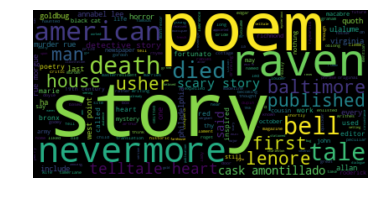

In [140]:
#example output

answer = 'edgar allan poe'

title_string = answer
#frame = j[j['answer_modified'].str.contains(str(answer))]
frame = j[j.question_modified == answer]

ab = itertools.chain(*list(frame.answer_modified))
ab = list(ab)
ab = [item for item in ab if item is not '']
ab = [item.translate(str.maketrans('', '', string.punctuation)) for item in ab]
ab = [lemmatizer.lemmatize(item) for item in ab]

container_ship = []
for answ in frame.answer_modified:
    answ = str(answ)
    answ2 = answ.replace("'", "").replace("[", "").replace("]", "").replace(",", "")
    answ2 = list(answ2.split(" "))
    for item in answ2:
        container_ship.append(item)

ab = container_ship
ab = [item for item in ab if item is not '']
ab = [item.translate(str.maketrans('', '', string.punctuation)) for item in ab]
ab = [lemmatizer.lemmatize(item) for item in ab]

answer_string = listToString(ab)

stopwords_list.extend(['book', 'author', 'lit', 'literature', 'wrote', 'write', 'authors', 'poet',\
                      'novel', 'novelist', 'writer', 'penned', 'books', 'novels', 'first' 'title', 'reading']) #lit


wordcloud = WordCloud(stopwords=stopwords_list).generate(answer_string)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [143]:
#loop through whole list and save to directory of your choice (directory must exist before you run this)

for answer in top_answers: #top_answers:
    title_string = answer
    #frame = j[j['answer_modified'].str.contains(str(answer))]
    frame = j[j.question_modified == answer]
    
    ab = itertools.chain(*list(frame.answer_modified))
    ab = list(ab)
    ab = [item for item in ab if item is not '']
    ab = [item.translate(str.maketrans('', '', string.punctuation)) for item in ab]
    ab = [lemmatizer.lemmatize(item) for item in ab]
    
    container_ship = []
    for answ in frame.answer_modified:
        answ = str(answ)
        answ2 = answ.replace("'", "").replace("[", "").replace("]", "").replace(",", "")
        answ2 = list(answ2.split(" "))
        for item in answ2:
            container_ship.append(item)
            
    ab = container_ship
    ab = [item for item in ab if item is not '']
    ab = [item.translate(str.maketrans('', '', string.punctuation)) for item in ab]
    ab = [lemmatizer.lemmatize(item) for item in ab]
    
    answer_string = listToString(ab)
    
    stopwords_list.extend(['book', 'author', 'lit', 'literature', 'wrote', 'write', 'authors', 'poet',\
                          'novel', 'novelist', 'writer', 'penned', 'books', 'novels', 'first' 'title', 'reading'])
    
    '''stopwords_list.extend(['film', 'movie', 'star', 'stars', 'actor', 'actress', 'one', 'type', 'name',\
                          'featuring', 'director', 'directors', 'directed'])'''
    
    '''
    stopwords_list.extend(['fruit', 'vegetable', 'dish', 'food', 'item', 'one', 'type', 'name',\
                          'variety'])'''
    
    '''stopwords_list.extend(['country', 'nation', 'state', 'world', 'city', 'lake',\
                           'capital', 'border', 'borders', 'continent', 'region',\
                          'area', 'island', 'ha', 'county', 'school', 'university',\
                          'named', 'land', 'year', 'film', 'won', 'novel', 'new', 'became',\
                           '1900s', '1910s','1920s', '1930s','1940s', '1950s','1960s', '1970s',\
                           '1980s','1990s', '2000s', '2010s', '2020s',\
                          'color', 'first', 'religion', 'man', 'woman', 'name', 'one'])'''
    
    try:
        wordcloud = WordCloud(stopwords=stopwords_list).generate(answer_string)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        try:
            plt.savefig('cluster_flashcards/literature/' + str(title_string) + '.png', dpi=300)
        except FileNotFoundError:
            pass
        print(title_string)
        plt.close()
    except ValueError:
        pass

edgar allan poe


## Correlation of Topics by Round

I didn't use this in my prep, but just thought it'd be interesting to see if this yielded any insight into the way the question boards are constructed. As it turns out: kinda; the most interesting thing is that "sports" might be considered a pop culture topic by Jeopardy! clue team, which I hadn't considered.

In [231]:
r1_cols = ['r1_art', 'r1_business', 'r1_entertainment', 'r1_fashion', 'r1_film',\
       'r1_food', 'r1_geography', 'r1_government', 'r1_history', 'r1_language',\
       'r1_literature', 'r1_miscellaneous', 'r1_music', 'r1_people',\
       'r1_religion', 'r1_science', 'r1_sports', 'r1_television',\
       'r1_theater']
r2_cols = ['r2_art', 'r2_business', 'r2_entertainment', 'r2_fashion', 'r2_film',\
       'r2_food', 'r2_geography', 'r2_government', 'r2_history', 'r2_language',\
       'r2_literature', 'r2_miscellaneous', 'r2_music', 'r2_people',\
       'r2_religion', 'r2_science', 'r2_sports', 'r2_television', 'r2_theater']

In [232]:
round_one = qs_clusters[['air_date', 'category', 'cat1', 'cat2', 'wt1']][qs_clusters['round'] == 1]
round_one = round_one.sort_values('air_date')
round_one = round_one.drop_duplicates()

round_one

round_two = qs_clusters[['air_date', 'category', 'cat1', 'cat2', 'wt1']][qs_clusters['round'] == 2]
round_two = round_two.sort_values('air_date')
round_two = round_two.drop_duplicates()

round_two

,air_date,category,cat1,cat2,wt1
1513,1984-09-10,NATIONAL LANDMARKS,history,NaN,1.0
1682,1984-09-10,4-LETTER WORDS,miscellaneous,NaN,1.0
1028,1984-09-10,THE BIBLE,religion,NaN,1.0
1500,1984-09-10,\'50'S TV,television,NaN,1.0
1515,1984-09-10,NOTORIOUS,history,NaN,1.0
...,...,...,...,...,...
375847,2020-06-12,PLAYING THE VILLAIN,film,NaN,1.0
375852,2020-06-12,OUTSIDE OF ME,miscellaneous,NaN,1.0
375841,2020-06-12,TROOP-POURRI,history,NaN,1.0
375834,2020-06-12,COLORFUL CITIES,geography,NaN,1.0


In [233]:
x = pd.get_dummies(round_one.cat1, prefix = 'r1')
y = pd.get_dummies(round_one.cat2, prefix = 'r1')
y['r1_fashion'] = int(0)
y = y.reindex(columns=['r1_art', 'r1_business', 'r1_entertainment', 'r1_fashion', 'r1_film',\
       'r1_food', 'r1_geography', 'r1_government', 'r1_history', 'r1_language',\
       'r1_literature', 'r1_miscellaneous', 'r1_music', 'r1_people',\
       'r1_religion', 'r1_science', 'r1_sports', 'r1_television',\
       'r1_theater']) #there was no cat2 "fashion" so had to insert so the adding works

round_one_encoded = x.reindex_like(y).fillna(0) + y.fillna(0).fillna(0)
round_one_encoded['wt'] = round_one['wt1']
round_one_encoded['air_date'] = round_one['air_date']

x = pd.get_dummies(round_two.cat1, prefix = 'r2')
y = pd.get_dummies(round_two.cat2, prefix = 'r2')

round_two_encoded = x.reindex_like(y).fillna(0) + y.fillna(0).fillna(0)
round_two_encoded['wt'] = round_two['wt1']
round_two_encoded['air_date'] = round_two['air_date']

In [234]:
for col in r1_cols:
    round_one_encoded[col] = round_one_encoded[col] * round_one_encoded['wt']

for col in r2_cols:
    round_two_encoded[col] = round_two_encoded[col] * round_two_encoded['wt']

In [235]:
round_one_encoded = round_one_encoded.groupby('air_date').sum()
round_two_encoded = round_two_encoded.groupby('air_date').sum()

correlation = round_two_encoded.merge(round_one_encoded, how='outer', left_index=True, right_index=True)

correlation = correlation.drop(columns=['r1_miscellaneous', 'r2_miscellaneous', 'wt_y', 'wt_x'])

correlation.head()

,r2_art,r2_business,r2_entertainment,r2_fashion,r2_film,r2_food,r2_geography,r2_government,r2_history,r2_language,...,r1_history,r1_language,r1_literature,r1_music,r1_people,r1_religion,r1_science,r1_sports,r1_television,r1_theater
air_date,,,,,,,,,,,,,,,,,,,,,
1984-09-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.5,0.0,0.0,0.0
1984-09-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1984-09-12,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1984-09-13,0.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0,1.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1984-09-14,0.0,0.5,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [236]:
corr_mat = correlation.corr(method='pearson')

#https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/

upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
unique_corr_pairs = upper_corr_mat.unstack().dropna()
sorted_mat = unique_corr_pairs.sort_values()
sorted_mat.to_csv('sorted_mat_no_misc.csv')

In [237]:
pd.DataFrame(data=sorted_mat, columns=['corr'])

corr
r1_literature r2_literature    -0.282718
r1_geography  r2_geography     -0.186216
r2_music      r2_film          -0.184296
r2_theater    r2_literature    -0.172633
r1_science    r2_science       -0.167761
...                                  ...
r1_history    r2_science        0.062736
r1_literature r2_geography      0.067097
r1_film       r1_entertainment  0.069819
              r2_music          0.081072
r1_music      r2_film           0.095357

[630 rows x 1 columns]

In [238]:
game_search = round_one.append(round_two)
game_search[game_search['air_date'] == '2017-04-21']

,air_date,category,cat1,cat2,wt1
293273,2017-04-21,SCHWARZENEGGER,film,NaN,1.0
268828,2017-04-21,ALMA MATERS,geography,NaN,1.0
14652,2017-04-21,LITERATURE,literature,NaN,1.0
348524,2017-04-21,IT'S NOT A TUBER!,food,NaN,1.0
348520,2017-04-21,U.S. HERSTORY,people,history,0.5
140033,2017-04-21,"CROSSWORD CLUES ""D\""",miscellaneous,NaN,1.0
348531,2017-04-21,IT'S ALL SAM-ANTICS,miscellaneous,NaN,1.0
26997,2017-04-21,BALLET,theater,NaN,1.0
127433,2017-04-21,ANIMALS ON THE MAP,geography,science,0.5
306183,2017-04-21,1990s NO. 1 ALBUMS,music,NaN,1.0


## Rolling Average from Assessments

This is just code I used to pull my rolling average of my self-assessments out from the manual list.

In [269]:
from datetime import date, timedelta

cats_all = ['art','business','entertainment','fashion','film','food','geography','government','history',\
 'language','literature','miscellaneous','music','people','religion','science','sports','television','theater']

assessments = pd.read_csv('jeop_assessments.csv')
assessments.Category = [i.lower() for i in assessments.Category]
assessments.Date = pd.to_datetime(assessments['Date'])
assessments = pd.merge(assessments, cats_values, how='left', left_on='Category', right_on='category')
assessments = assessments[['Date', 'Category', 'Index', 'percentages']]

assessments

,Date,Category,Index,percentages
0,2021-08-15,film,31.045407,4.731
1,2021-08-15,food,26.284994,3.917
2,2021-08-15,geography,29.355169,11.473
3,2021-08-15,history,28.984419,11.333
4,2021-08-15,literature,20.072289,6.942
...,...,...,...,...
68,2021-11-28,geography,32.422181,11.473
69,2021-11-28,literature,27.835052,6.942
70,2021-11-28,people,33.126545,4.535
71,2021-11-28,religion,30.122646,2.149


In [270]:
nextdate = '2021-08-15'
subframe = assessments[assessments.Date < '2021-08-20']
subframe['weighted'] = (subframe['Index']*2) * (subframe['percentages']/100)
sum(subframe.weighted)

C:\Users\Zach Gozlan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


58.43040137731799

In [278]:
progress = pd.DataFrame(columns=['Date', 'wt_sum'])
nextdate = pd.to_datetime('2021-08-15').normalize()
sumwt = 0
while nextdate < pd.to_datetime('2021-11-29').normalize(): #tape day
    sumwt = 0
    assessments_sub = assessments[assessments.Date < nextdate]
    assessments_sub = assessments_sub.sort_values(by=['Date', 'Category'])
    assessments_sub = assessments_sub.drop_duplicates(subset=['Category'], keep='last')
    assessments_sub['weighted'] = (assessments_sub['Index']*2) * (assessments_sub['percentages']/100)
    progress = progress.append({'Date': nextdate, 'wt_sum': sum(assessments_sub.weighted)}, ignore_index=True)
    nextdate = nextdate + datetime.timedelta(days=1)
    
progress

,Date,wt_sum
0,2021-08-15,0
1,2021-08-16,48.5755
2,2021-08-17,58.4304
3,2021-08-18,58.4304
4,2021-08-19,58.4304
...,...,...
101,2021-11-24,65.0971
102,2021-11-25,65.0971
103,2021-11-26,65.0971
104,2021-11-27,65.0971
